# Audio Digital Classification

### Installing libraries

We will work with `torch` version `1.7.1` (with the corresponding version of `touchaudio`).

While the installation is in progress, you can run your eyes through the [documentation](https://pytorch.org/audio/stable/transforms.html) to `torchaudio` – from this library, we will only need a few transforms, as well as audio loading functions.

In [1]:
! apt-get update && apt-get install -y sox python3.7-dev python3.7-distutils curl

Чтение списков пакетов… Готово
E: Не удалось открыть файл блокировки /var/lib/apt/lists/lock - open (13: Отказано в доступе)
E: Невозможно заблокировать каталог /var/lib/apt/lists/
W: Проблема при удалении файла /var/cache/apt/pkgcache.bin - RemoveCaches (13: Отказано в доступе)
W: Проблема при удалении файла /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Отказано в доступе)


In [8]:
! pip install \
    torch==1.7.1+cu101 \
    torchvision==0.8.2+cu101 \
    torchaudio==0.7.2 \
    -f https://download.pytorch.org/whl/torch_stable.html

! pip install numpy==1.17.5 matplotlib==3.1.3 tqdm==4.54.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 11 kB/s s eta 0:00:012��███████████▊| 728.4 MB 84.1 MB/s eta 0:00:01
     |████████████████████████████████| 12.8 MB 1.5 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0
    Uninstalling torchvision-0.14.0:
      Successfully uninstalled torchvision-0.14.0
     |████████████████████████████████| 20.5 MB 432 kB/s eta 0:00:01     |███████████████████████████▉    | 17.8 MB 151 kB/s eta 0:00:18
     |████████████████████████████████| 13.1 MB 206 kB/s eta 0:00:01
     |████████████████████████████████| 69 kB 8.0 MB/s  eta 0:00:01
ERROR: xarray 2022.6.0 has requirement numpy>=1.19, but you'll have numpy 1.17.5 which is incompatible.
ERROR: scipy 1.10.0 has requirement numpy<1

### Obtaining AudioMNIST dataset 
<!-- 0️⃣1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣8️⃣9️⃣ -->

To get the dataset, clone the repository (`~1Gb`) running the code below:

In [1]:
! git clone https://github.com/soerenab/AudioMNIST

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30122, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 30122 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30122/30122), 944.54 MiB | 25.65 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (30018/30018), done.


In [1]:
import torchaudio

/data/home/vitya/DataPrep/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
import torch

# import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import shutil

from typing import List, Tuple
from glob import glob

import os
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Audio

%matplotlib inline

DIGIT_NAMES = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
]

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

if torch.cuda.is_available():
    print("GPU found! 🎉")
    device = "cuda"
else:
    print("Only CPU found! 💻")
    device = "cpu"

GPU found! 🎉


# Audio Partitioning via Voice Activity Detection


### Preprocessing

The recording may differ not only in format (be `mp3`, `ogg`), but in sampling rate (`22050Hz`, `44100Hz`), being a stereo recording, and so on. 

To bring the record to the unified format we need:

In [4]:
# -> 16kHz, 16bit, mono
#!sox cifarki_audio.wav -r 16000 -b 16 -c 1 recording_16kHz.wav

In [5]:
path = "recording_16kHz.wav"

x, sr = torchaudio.load(path)
x = x[0].numpy()

print(", ".join(DIGIT_NAMES))
display(Audio(x, rate=sr))

zero, one, two, three, four, five, six, seven, eight, nine


### Voice Activity Detection 

The energy of a discrete audio sequence $x_{1:T}$ of length $T$ is defined as:

$$
\mathrm{E} = \sum_{t=1}^T |x_t|^2
$$


In [6]:
def plot_signal_energies(x, sr, energies_db, window_size=512, intervals=None):
    fig, ax = plt.subplots(figsize=(len(x) / sr, 2.5))
    ax.plot(x, color="#20639b", label="audio signal")
    plt.xticks(np.arange(0, len(x), sr), np.int32(np.arange(0, len(x), sr) / sr))
    plt.grid(alpha=0.5, linestyle="--")
    plt.xlabel("time [s]")
    plt.ylabel("amplitude")
    plt.ylim([-0.51, 0.51])
    plt.xlim(-50, len(x) + 50)
    if intervals:
        for a, b in intervals:
            ax.add_patch(
                patches.Rectangle(
                    (a, -0.5), b - a, 50, linewidth=2, edgecolor="red", facecolor="none"
                )
            )

    plt.twinx()
    plt.plot(
        np.linspace(0, len(x), len(energies_db)),
        energies_db,
        color="#3caea3",
        label=f"energy (window size = {window_size})",
    )
    plt.ylabel("Energy [dB]")
    plt.legend(loc="best")
    plt.show()

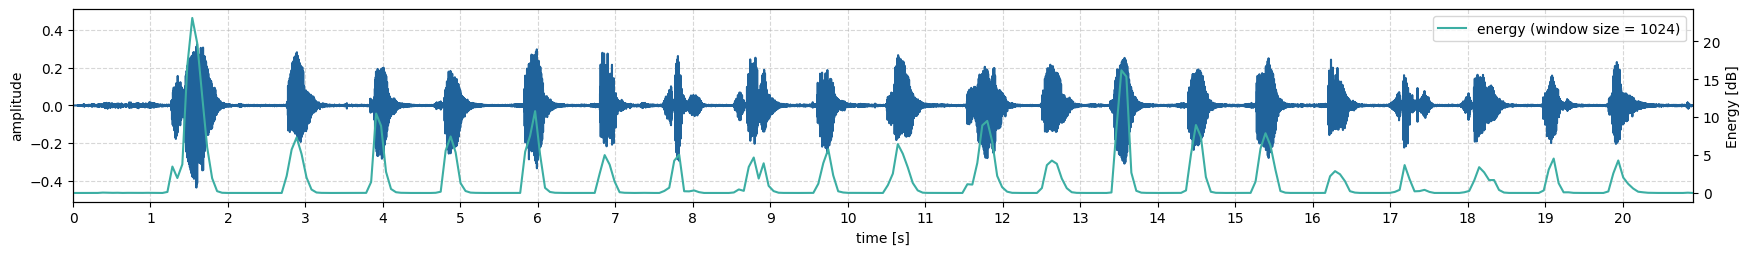

In [7]:
win_size = 1024

x, sr = torchaudio.load(path)
x = x[0].numpy()

energies_db = []
for i in range(len(x) // win_size + 1):
    x_win = x[i * win_size : (i + 1) * win_size]

    energy = (x_win**2).sum()

    energies_db.append(energy)

energies_db = np.array(energies_db)

plot_signal_energies(x, sr, energies_db, win_size)

### Partitioning the Audio


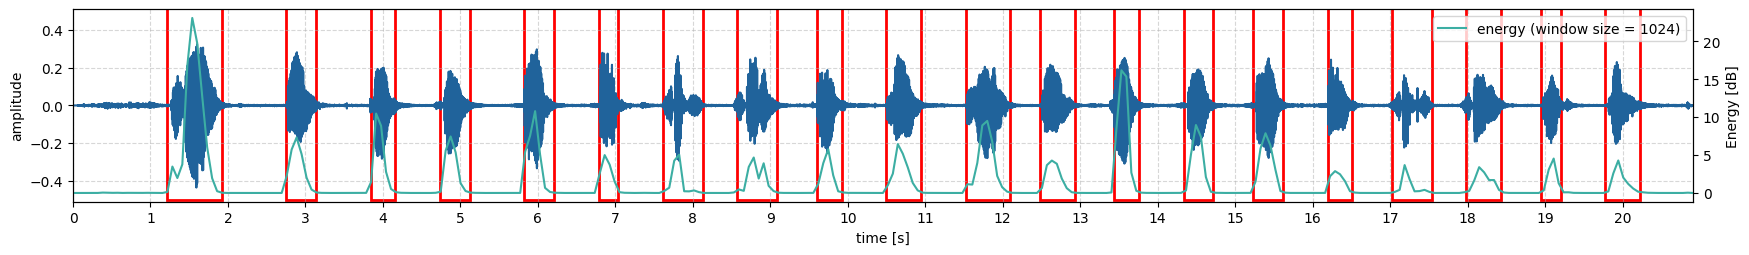

In [8]:
# list of digit intervals [(a_0, b_0), ...]
# where a_i -- first audio sample of spoken word, b_i -- last sample
intervals = []

started = False
for k, e in enumerate(energies_db):
    if not started:
        if e > 0.1:
            start = k
            started = True
    else:
        if e < 0.1:
            end = k
            started = False

            intervals.append((start * 1024, end * 1024))


plot_signal_energies(x, sr, energies_db, win_size, intervals)

In [9]:
test_directory = "AudioMNIST/data/test"
if not os.path.exists(test_directory):
    os.mkdir(test_directory)

n = 0
for a, b in intervals:
    x_digit = x[a:b]
    path = f"{test_directory}/{n % 10}_test_{n // 10}.wav"
    print(f'"{DIGIT_NAMES[n % 10]}" -> {path}')
    n += 1

    torchaudio.save(path, torch.FloatTensor(x_digit), sr)
    display(Audio(path))

"zero" -> AudioMNIST/data/test/0_test_0.wav


"one" -> AudioMNIST/data/test/1_test_0.wav


"two" -> AudioMNIST/data/test/2_test_0.wav


"three" -> AudioMNIST/data/test/3_test_0.wav


"four" -> AudioMNIST/data/test/4_test_0.wav


"five" -> AudioMNIST/data/test/5_test_0.wav


"six" -> AudioMNIST/data/test/6_test_0.wav


"seven" -> AudioMNIST/data/test/7_test_0.wav


"eight" -> AudioMNIST/data/test/8_test_0.wav


"nine" -> AudioMNIST/data/test/9_test_0.wav


"zero" -> AudioMNIST/data/test/0_test_1.wav


"one" -> AudioMNIST/data/test/1_test_1.wav


"two" -> AudioMNIST/data/test/2_test_1.wav


"three" -> AudioMNIST/data/test/3_test_1.wav


"four" -> AudioMNIST/data/test/4_test_1.wav


"five" -> AudioMNIST/data/test/5_test_1.wav


"six" -> AudioMNIST/data/test/6_test_1.wav


"seven" -> AudioMNIST/data/test/7_test_1.wav


"eight" -> AudioMNIST/data/test/8_test_1.wav


"nine" -> AudioMNIST/data/test/9_test_1.wav


# Data Processing Pipeline

### Dataloader


In [10]:
class AudioMNISTDataset(data.Dataset):
    def __init__(self, directory: str, mode="train", transform=None):
        self.mode = mode
        self.transform = transform
        assert mode == "train" or mode == "valid" or mode == "test"
        self.filepaths = []
        self.labels = []
        for filepath in sorted(glob(os.path.join(directory, "*", "?_*_*.wav"))):
            digit, speaker, example_id = (
                os.path.basename(filepath).replace(".wav", "").split("_")
            )
            add = False
            if speaker == "test" and mode == "test":
                add = True
            if speaker != "test" and int(speaker) % 6 == 0 and mode == "valid":
                add = True
            if speaker != "test" and int(speaker) % 6 != 0 and mode == "train":
                add = True
            if add:
                self.filepaths.append(filepath)
                self.labels.append(int(digit))

        print(f"Dataset [{mode}]: {len(self.filepaths)} audios")

    def __getitem__(self, idx) -> Tuple[torch.FloatTensor, torch.LongTensor]:
        x, sr = torchaudio.load(self.filepaths[idx])
        y = torch.LongTensor([self.labels[idx]])[0]

        # Conversion to correct sample rate...
        effects = [
            ["gain", "-n", "0"],  # apply 10 db attenuation
            ["remix", "-"],  # merge all the channels
            ["rate", "16000"],
        ]
        x, sr = torchaudio.sox_effects.apply_effects_tensor(x, sr, effects)

        if self.transform is not None:
            out_feat = self.transform(x[0]).clamp(1e-5)
        else:
            out_feat = x[0]

        # out_feat: audio features
        # y: target digit class
        return out_feat, y

    def __len__(self):
        return len(self.filepaths)


train_dataset = AudioMNISTDataset("AudioMNIST/data", mode="train")
valid_dataset = AudioMNISTDataset("AudioMNIST/data", mode="valid")
test_dataset = AudioMNISTDataset("AudioMNIST/data", mode="test")

Dataset [train]: 25000 audios
Dataset [valid]: 5000 audios
Dataset [test]: 20 audios


In [11]:
#!L
train_audio_transforms = nn.Sequential(
    # Add features transformations here
    torchaudio.transforms.MelSpectrogram()
    # torchaudio.transforms.AmplitudeToDB(),
    # torchaudio.transforms.MFCC(log_mels=True)
)

test_audio_transforms = nn.Sequential(
    # torchaudio.transforms.AmplitudeToDB(),
    torchaudio.transforms.MelSpectrogram()
    # torchaudio.transforms.MFCC(log_mels=True)
)

/data/home/vitya/DataPrep/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


/data/home/vitya/DataPrep/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/data/home/vitya/DataPrep/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


visualize dataset for training


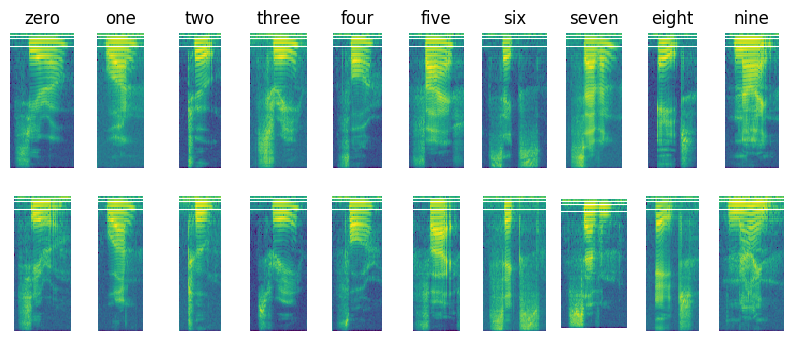

visualize dataset for validation


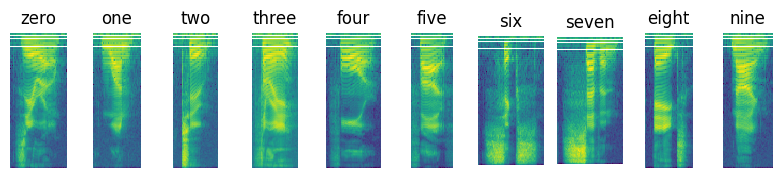

In [12]:
def show_some_examples(dataset, K, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    for digit in range(10):
        indices = np.where(np.array(dataset.labels) == digit)[0]
        for i in range(K):
            x, y = dataset[indices[i]]
            x = torch.log(test_audio_transforms(x))
            ax = fig.add_subplot(3, 10, digit + i * 10 + 1)
            # rotate
            if i == 0:
                ax.set_title(DIGIT_NAMES[digit])
            ax.imshow(x)
            ax.axis("off")
    plt.show()


print("visualize dataset for training")
show_some_examples(train_dataset, 2)

print("visualize dataset for validation")
show_some_examples(valid_dataset, 1)

# print("visualize dataset for testing")
# show_some_examples(test_dataset, 1)

In [13]:
from torch.nn.utils.rnn import pad_sequence


class Collate:
    def __init__(self, train=False) -> None:
        super(Collate, self).__init__()

        self.train = train

    def __call__(
        self, batch: List[Tuple[torch.Tensor, torch.Tensor]]
    ) -> Tuple[torch.Tensor, ...]:
        """
        :param batch: is a list of tuples of [features, label], where features has dimensions [n_features, length]
        "returns features, lengths, labels:
              features is a Tensor [batchsize, features, max_length]
              lengths is a Tensor of lengths [batchsize]
              labels is a Tesnor of targets [batchsize]
        """

        features = []
        labels = torch.LongTensor(len(batch)).zero_()
        lengths = torch.LongTensor(len(batch)).zero_()
        for k, elem in enumerate(batch):
            # print(elem[0].size())
            features.append(torch.log(elem[0]).permute(1, 0))
            labels[k] = elem[1]
            lengths[k] = elem[0].size()[1]

        # return features, lengths, labels
        features = pad_sequence(features, batch_first=True)

        return features, lengths, labels

In [14]:
BS = 32


train_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="train", transform=train_audio_transforms
)
valid_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="valid", transform=test_audio_transforms
)
test_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="test", transform=test_audio_transforms
)


train_collate_fn = Collate(train=True)
test_collate_fn = Collate(train=False)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=BS,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    collate_fn=train_collate_fn,
)
valid_loader = data.DataLoader(
    valid_dataset,
    batch_size=BS,
    shuffle=False,
    num_workers=4,
    collate_fn=test_collate_fn,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=BS,
    shuffle=False,
    num_workers=1,
    collate_fn=test_collate_fn,
)

xs, ls, ys = next(iter(train_loader))
print(xs.size(), ls.size(), ys.size())
print(xs.dtype, ls.dtype, ys.dtype)

# Assessment
assert len(xs.size()) == 3
assert xs.size()[0] == ls.size()[0] and ls.size()[0] == ys.size()[0]
assert xs.dtype == torch.float32
assert ys.dtype == torch.int64
assert ls.dtype == torch.int64

Dataset [train]: 25000 audios
Dataset [valid]: 5000 audios
Dataset [test]: 20 audios
torch.Size([32, 73, 128]) torch.Size([32]) torch.Size([32])
torch.float32 torch.int64 torch.int64


# Implementing and training  Digit Classifier

In [15]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.cnns = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2, 2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.classification_head = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        z = self.cnns(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        out = self.classification_head(z)
        return out


def create_model_and_optimizer(device):
    model = Model(10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    return model, optimizer

### Training and Evaluation Functions

In [16]:
# Training and evaluation function
def train(model, optimizer, loader, metrics, epoch):
    model.train()

    losses = []
    for x, lengths, y in tqdm(
        loader, total=len(loader), desc=f"epoch train: {str(epoch).zfill(3)}"
    ):
        x, y = x.to(device), y.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        y_pred = model(x, lengths)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    metrics["train_loss"].append(np.mean(losses))

    return np.mean(losses)


def evaluate(model, loader, metrics, mode, epoch):
    model.eval()

    losses = []
    cm = np.zeros((10, 10), dtype=np.int32)
    with torch.no_grad():
        valid_losses = []
        for x, lengths, y in tqdm(
            loader,
            total=len(loader),
            desc=f"epoch {mode}: {str(epoch).zfill(3)}".format(mode),
        ):
            x, y = x.to(device), y.to(device)
            lengths = lengths.to(device)

            y_pred = model(x, lengths)
            loss = F.cross_entropy(y_pred, y)
            losses.append(loss.item())

            y_pred = y_pred.argmax(axis=-1)
            for i in range(len(x)):
                cm[y[i].item(), y_pred[i].item()] += 1

    accuracy = np.trace(cm) / np.sum(cm)

    metrics[f"{mode}_loss"].append(np.mean(losses))
    metrics[f"{mode}_accuracy"].append(accuracy)
    metrics[f"{mode}_confusion"].append(cm)

    return np.mean(losses), accuracy


def train_from_scratch(
    model, optimizer, train_loader, valid_loader, test_loader, num_epochs
):
    metrics = {
        "train_loss": [],
        "valid_loss": [],
        "valid_accuracy": [],
        "valid_confusion": [],
        "test_loss": [],
        "test_accuracy": [],
        "test_confusion": [],
    }

    best_valid_accuracy = 0.0
    for epoch in range(num_epochs):
        train_loss = train(model, optimizer, train_loader, metrics, epoch)

        val_loss, val_acc = evaluate(model, valid_loader, metrics, "valid", epoch)
        test_loss, test_acc = evaluate(model, test_loader, metrics, "test", epoch)

        print(
            f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f}, val_acc: {val_acc:5.3f} (best: {best_valid_accuracy:5.3f})"
        )
        print(
            f"epoch: {str(epoch).zfill(3)} | test_loss: {test_loss:5.3f} (test_acc: {test_acc:5.3f})"
        )

        if metrics["valid_accuracy"][-1] > best_valid_accuracy:
            best_valid_accuracy = metrics["valid_accuracy"][-1]
            torch.save(
                {"state_dict": model.state_dict(), "metrics": metrics}, checkpoint_path
            )

    return metrics

### Main Training and Evaluation Loop

In [38]:
# Training Loop
torch.manual_seed(0)
torch.set_deterministic(True)
np.random.seed(0)
load = False

checkpoint_path = "model.pth"
model, optimizer = create_model_and_optimizer(device)

if os.path.exists(checkpoint_path) and load:
    print(f"Loading model weights from {checkpoint_path}")
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["state_dict"])
    metrics = ckpt["metrics"]
    evaluate(model, valid_loader, metrics, "valid")
    evaluate(model, test_loader, metrics, "test")
else:
    print("Training model from scratch..")
    metrics = train_from_scratch(
        model, optimizer, train_loader, valid_loader, test_loader, 10
    )

[W Context.cpp:69] Warning: torch.set_deterministic is in beta, and its design and  functionality may change in the future. (function operator())


Training model from scratch..


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 000 | train_loss: 0.927, val_loss: 0.389, val_acc: 0.904 (best: 0.000)
epoch: 000 | test_loss: 1.778 (test_acc: 0.500)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 001 | train_loss: 0.243, val_loss: 0.223, val_acc: 0.938 (best: 0.904)
epoch: 001 | test_loss: 1.624 (test_acc: 0.550)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 002 | train_loss: 0.129, val_loss: 0.155, val_acc: 0.954 (best: 0.938)
epoch: 002 | test_loss: 1.660 (test_acc: 0.550)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 003 | train_loss: 0.085, val_loss: 0.155, val_acc: 0.955 (best: 0.954)
epoch: 003 | test_loss: 1.535 (test_acc: 0.550)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 004 | train_loss: 0.061, val_loss: 0.107, val_acc: 0.967 (best: 0.955)
epoch: 004 | test_loss: 1.890 (test_acc: 0.550)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 005 | train_loss: 0.044, val_loss: 0.106, val_acc: 0.969 (best: 0.967)
epoch: 005 | test_loss: 1.548 (test_acc: 0.550)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 006 | train_loss: 0.033, val_loss: 0.085, val_acc: 0.974 (best: 0.969)
epoch: 006 | test_loss: 1.007 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 007 | train_loss: 0.030, val_loss: 0.073, val_acc: 0.976 (best: 0.974)
epoch: 007 | test_loss: 1.379 (test_acc: 0.600)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 008 | train_loss: 0.023, val_loss: 0.098, val_acc: 0.969 (best: 0.976)
epoch: 008 | test_loss: 1.553 (test_acc: 0.550)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 009 | train_loss: 0.016, val_loss: 0.116, val_acc: 0.971 (best: 0.976)
epoch: 009 | test_loss: 0.742 (test_acc: 0.750)


### Visualization of the results


In [24]:
# Visualization helper function
def plot_accuracies(valid_accuracy, test_accuracy, best_epoch):
    best_valid = valid_accuracy[best_epoch]
    best_test = test_accuracy[best_epoch]

    plt.figure(figsize=(7, 3))
    plt.title("Accuracy")
    plt.plot(valid_accuracy, label="valid", color="#20639b")
    plt.plot(test_accuracy, label="test", color="#3caea3")
    plt.grid(linestyle="--", alpha=0.5)
    plt.vlines(best_epoch, 0.6, 1, color="#ed553b", linestyle="--", label="best")
    plt.hlines(best_valid, 0, best_epoch, linestyle="--", color="#555555")
    plt.hlines(best_test, 0, best_epoch, linestyle="--", color="#555555")
    plt.plot(best_epoch, best_valid, marker="o", color="#20639b")
    plt.plot(best_epoch, best_test, marker="o", color="#3caea3")
    plt.text(0, best_valid - 0.02, f"{best_valid:.4f}")
    plt.text(0, best_test - 0.02, f"{best_test:.4f}")
    plt.ylim(0.8, 1.01)
    plt.xlim(0, len(valid_accuracy) - 1)
    plt.xticks(range(len(valid_accuracy)))
    plt.yticks(np.linspace(0.8, 1.0, 11))
    plt.legend()
    plt.show()


def plot_confusion_matrix(cm, names, title="Confusion matrix", normalize=False):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.get_cmap("Blues"))
    plt.title(title)

    if names is not None:
        tick_marks = np.arange(len(names))
        plt.xticks(tick_marks, names, rotation=45)
        plt.yticks(tick_marks, names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            kwargs = {
                "color": "white" if cm[i, j] > thresh else "black",
                "horizontalalignment": "center",
            }
            if normalize:
                plt.text(j, i, "{:0.2f}".format(cm[i, j]), **kwargs)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), **kwargs)

    accuracy = np.trace(cm) / float(np.sum(cm))

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4f}")
    plt.show()

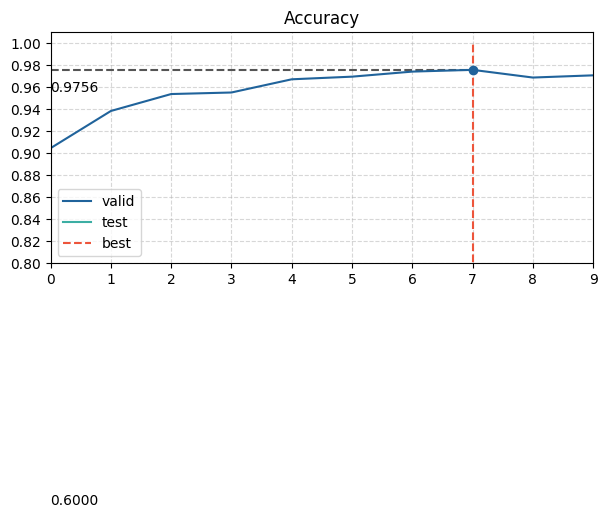

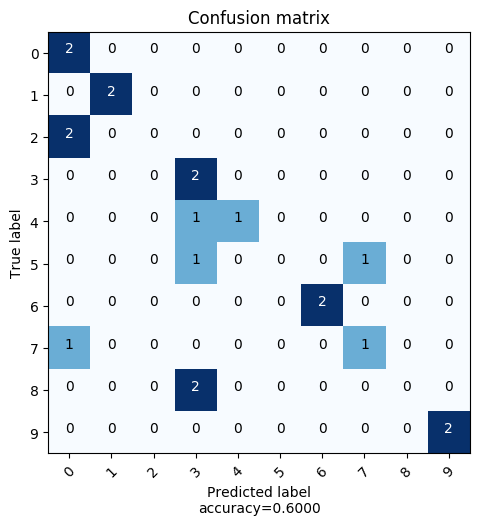

In [40]:
# choosing model by best accuracy on validation set
best = np.argmax(metrics["valid_accuracy"])
best_cm = metrics["test_confusion"][best]

plot_accuracies(metrics["valid_accuracy"], metrics["test_accuracy"], best)
plot_confusion_matrix(best_cm, range(10))

In [17]:
#!L
train_audio_transforms = nn.Sequential(
    # Add features transformations here
    torchaudio.transforms.MelSpectrogram(),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=20),
    torchaudio.transforms.TimeMasking(time_mask_param=20)
    # torchaudio.transforms.AmplitudeToDB(),
    # torchaudio.transforms.MFCC(log_mels=True)
)

test_audio_transforms = nn.Sequential(
    # torchaudio.transforms.AmplitudeToDB(),
    torchaudio.transforms.MelSpectrogram()
    # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),
    # torchaudio.transforms.TimeMasking(time_mask_param=20)
    # torchaudio.transforms.MFCC(log_mels=True)
)

In [18]:
train_dataset = AudioMNISTDataset("AudioMNIST/data", mode="train")
valid_dataset = AudioMNISTDataset("AudioMNIST/data", mode="valid")
test_dataset = AudioMNISTDataset("AudioMNIST/data", mode="test")

Dataset [train]: 25000 audios
Dataset [valid]: 5000 audios
Dataset [test]: 20 audios


visualize dataset for training


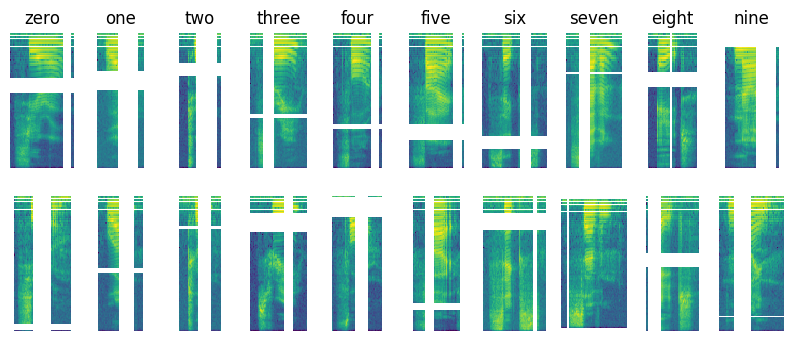

visualize dataset for validation


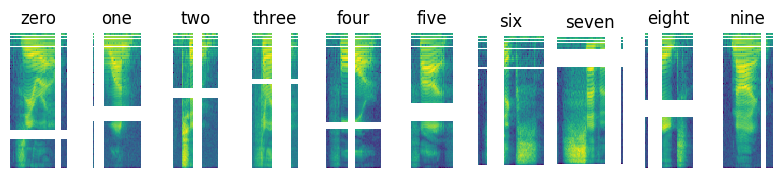

In [19]:
def show_some_examples(dataset, K, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    for digit in range(10):
        indices = np.where(np.array(dataset.labels) == digit)[0]
        for i in range(K):
            x, y = dataset[indices[i]]
            x = torch.log(train_audio_transforms(x))
            ax = fig.add_subplot(3, 10, digit + i * 10 + 1)
            # rotate
            if i == 0:
                ax.set_title(DIGIT_NAMES[digit])
            ax.imshow(x)
            ax.axis("off")
    plt.show()


print("visualize dataset for training")
show_some_examples(train_dataset, 2)

print("visualize dataset for validation")
show_some_examples(valid_dataset, 1)

# print("visualize dataset for testing")
# show_some_examples(test_dataset, 1)

In [20]:
BS = 32


train_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="train", transform=train_audio_transforms
)
valid_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="valid", transform=test_audio_transforms
)
test_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="test", transform=test_audio_transforms
)


train_collate_fn = Collate(train=True)
test_collate_fn = Collate(train=False)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=BS,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    collate_fn=train_collate_fn,
)
valid_loader = data.DataLoader(
    valid_dataset,
    batch_size=BS,
    shuffle=False,
    num_workers=4,
    collate_fn=test_collate_fn,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=BS,
    shuffle=False,
    num_workers=1,
    collate_fn=test_collate_fn,
)

xs, ls, ys = next(iter(train_loader))
print(xs.size(), ls.size(), ys.size())
print(xs.dtype, ls.dtype, ys.dtype)

# Assessment
assert len(xs.size()) == 3
assert xs.size()[0] == ls.size()[0] and ls.size()[0] == ys.size()[0]
assert xs.dtype == torch.float32
assert ys.dtype == torch.int64
assert ls.dtype == torch.int64

Dataset [train]: 25000 audios
Dataset [valid]: 5000 audios
Dataset [test]: 20 audios
torch.Size([32, 79, 128]) torch.Size([32]) torch.Size([32])
torch.float32 torch.int64 torch.int64


In [21]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.cnns = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2, 2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.classification_head = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        z = self.cnns(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        out = self.classification_head(z)
        return out


def create_model_and_optimizer(device):
    model = Model(10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    return model, optimizer

In [22]:
# Training Loop
torch.manual_seed(0)
torch.set_deterministic(True)
np.random.seed(0)
load = False

checkpoint_path = "model_test.pth"
model, optimizer = create_model_and_optimizer(device)

if os.path.exists(checkpoint_path) and load:
    print(f"Loading model weights from {checkpoint_path}")
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["state_dict"])
    metrics = ckpt["metrics"]
    evaluate(model, valid_loader, metrics, "valid")
    evaluate(model, test_loader, metrics, "test")
else:
    print("Training model from scratch..")
    metrics = train_from_scratch(
        model, optimizer, train_loader, valid_loader, test_loader, 40
    )

[W Context.cpp:69] Warning: torch.set_deterministic is in beta, and its design and  functionality may change in the future. (function operator())


Training model from scratch..


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 000 | train_loss: 0.569, val_loss: 0.123, val_acc: 0.960 (best: 0.000)
epoch: 000 | test_loss: 1.051 (test_acc: 0.450)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 001 | train_loss: 0.132, val_loss: 0.069, val_acc: 0.979 (best: 0.960)
epoch: 001 | test_loss: 0.874 (test_acc: 0.600)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 002 | train_loss: 0.090, val_loss: 0.039, val_acc: 0.992 (best: 0.979)
epoch: 002 | test_loss: 0.868 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 003 | train_loss: 0.074, val_loss: 0.063, val_acc: 0.980 (best: 0.992)
epoch: 003 | test_loss: 0.846 (test_acc: 0.550)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 004 | train_loss: 0.063, val_loss: 0.048, val_acc: 0.987 (best: 0.992)
epoch: 004 | test_loss: 0.905 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 005 | train_loss: 0.058, val_loss: 0.033, val_acc: 0.988 (best: 0.992)
epoch: 005 | test_loss: 0.450 (test_acc: 0.900)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 006 | train_loss: 0.048, val_loss: 0.034, val_acc: 0.990 (best: 0.992)
epoch: 006 | test_loss: 0.738 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 007 | train_loss: 0.045, val_loss: 0.032, val_acc: 0.990 (best: 0.992)
epoch: 007 | test_loss: 0.781 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 008 | train_loss: 0.047, val_loss: 0.045, val_acc: 0.987 (best: 0.992)
epoch: 008 | test_loss: 1.003 (test_acc: 0.600)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 009 | train_loss: 0.042, val_loss: 0.039, val_acc: 0.989 (best: 0.992)
epoch: 009 | test_loss: 0.807 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 010 | train_loss: 0.035, val_loss: 0.032, val_acc: 0.990 (best: 0.992)
epoch: 010 | test_loss: 0.628 (test_acc: 0.800)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 011 | train_loss: 0.034, val_loss: 0.030, val_acc: 0.991 (best: 0.992)
epoch: 011 | test_loss: 0.892 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 012 | train_loss: 0.037, val_loss: 0.027, val_acc: 0.991 (best: 0.992)
epoch: 012 | test_loss: 0.725 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 013 | train_loss: 0.034, val_loss: 0.033, val_acc: 0.991 (best: 0.992)
epoch: 013 | test_loss: 0.995 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 014 | train_loss: 0.032, val_loss: 0.042, val_acc: 0.989 (best: 0.992)
epoch: 014 | test_loss: 0.424 (test_acc: 0.900)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 015 | train_loss: 0.031, val_loss: 0.031, val_acc: 0.991 (best: 0.992)
epoch: 015 | test_loss: 0.813 (test_acc: 0.650)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 016 | train_loss: 0.026, val_loss: 0.042, val_acc: 0.988 (best: 0.992)
epoch: 016 | test_loss: 0.993 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 017 | train_loss: 0.027, val_loss: 0.029, val_acc: 0.992 (best: 0.992)
epoch: 017 | test_loss: 0.899 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 018 | train_loss: 0.029, val_loss: 0.022, val_acc: 0.993 (best: 0.992)
epoch: 018 | test_loss: 1.025 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 019 | train_loss: 0.026, val_loss: 0.017, val_acc: 0.995 (best: 0.993)
epoch: 019 | test_loss: 0.855 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 020 | train_loss: 0.025, val_loss: 0.046, val_acc: 0.988 (best: 0.995)
epoch: 020 | test_loss: 0.644 (test_acc: 0.850)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 021 | train_loss: 0.025, val_loss: 0.075, val_acc: 0.983 (best: 0.995)
epoch: 021 | test_loss: 0.756 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 022 | train_loss: 0.021, val_loss: 0.035, val_acc: 0.991 (best: 0.995)
epoch: 022 | test_loss: 1.013 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 023 | train_loss: 0.022, val_loss: 0.040, val_acc: 0.989 (best: 0.995)
epoch: 023 | test_loss: 0.798 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 024 | train_loss: 0.023, val_loss: 0.035, val_acc: 0.991 (best: 0.995)
epoch: 024 | test_loss: 0.635 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 025 | train_loss: 0.024, val_loss: 0.039, val_acc: 0.990 (best: 0.995)
epoch: 025 | test_loss: 0.846 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 026 | train_loss: 0.019, val_loss: 0.060, val_acc: 0.987 (best: 0.995)
epoch: 026 | test_loss: 0.790 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 027 | train_loss: 0.022, val_loss: 0.030, val_acc: 0.992 (best: 0.995)
epoch: 027 | test_loss: 0.484 (test_acc: 0.850)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 028 | train_loss: 0.020, val_loss: 0.034, val_acc: 0.991 (best: 0.995)
epoch: 028 | test_loss: 0.946 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 029 | train_loss: 0.021, val_loss: 0.029, val_acc: 0.993 (best: 0.995)
epoch: 029 | test_loss: 0.991 (test_acc: 0.750)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 030 | train_loss: 0.021, val_loss: 0.031, val_acc: 0.993 (best: 0.995)
epoch: 030 | test_loss: 1.045 (test_acc: 0.650)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 031 | train_loss: 0.020, val_loss: 0.033, val_acc: 0.991 (best: 0.995)
epoch: 031 | test_loss: 0.792 (test_acc: 0.800)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 032 | train_loss: 0.017, val_loss: 0.031, val_acc: 0.992 (best: 0.995)
epoch: 032 | test_loss: 1.098 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 033 | train_loss: 0.021, val_loss: 0.033, val_acc: 0.993 (best: 0.995)
epoch: 033 | test_loss: 0.779 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 034 | train_loss: 0.018, val_loss: 0.028, val_acc: 0.992 (best: 0.995)
epoch: 034 | test_loss: 0.607 (test_acc: 0.800)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 035 | train_loss: 0.016, val_loss: 0.021, val_acc: 0.994 (best: 0.995)
epoch: 035 | test_loss: 0.505 (test_acc: 0.800)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 036 | train_loss: 0.018, val_loss: 0.033, val_acc: 0.990 (best: 0.995)
epoch: 036 | test_loss: 0.963 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 037 | train_loss: 0.016, val_loss: 0.039, val_acc: 0.989 (best: 0.995)
epoch: 037 | test_loss: 0.787 (test_acc: 0.700)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 038 | train_loss: 0.017, val_loss: 0.029, val_acc: 0.991 (best: 0.995)
epoch: 038 | test_loss: 0.664 (test_acc: 0.800)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


epoch: 039 | train_loss: 0.016, val_loss: 0.030, val_acc: 0.993 (best: 0.995)
epoch: 039 | test_loss: 0.755 (test_acc: 0.800)


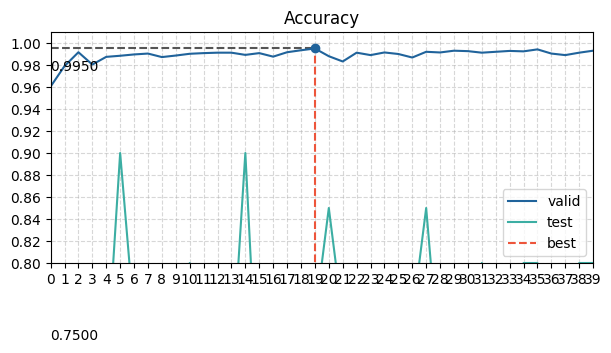

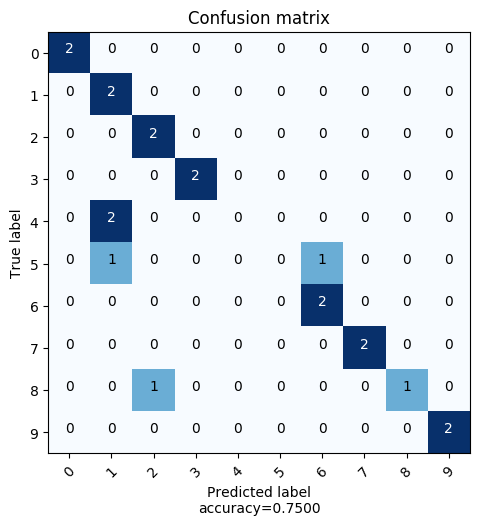

In [25]:
# choosing model by best accuracy on validation set
best = np.argmax(metrics["valid_accuracy"])
best_cm = metrics["test_confusion"][best]

plot_accuracies(metrics["valid_accuracy"], metrics["test_accuracy"], best)
plot_confusion_matrix(best_cm, range(10))

In [145]:
#!L
train_audio_transforms = nn.Sequential(
    # Add features transformations here
    torchaudio.transforms.MelSpectrogram(n_mels=256),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=40),
    torchaudio.transforms.TimeMasking(time_mask_param=40)
    # torchaudio.transforms.AmplitudeToDB(),
    # torchaudio.transforms.MFCC(log_mels=True)
)

test_audio_transforms = nn.Sequential(
    # torchaudio.transforms.AmplitudeToDB(),
    torchaudio.transforms.MelSpectrogram(n_mels=256)
    # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),
    # torchaudio.transforms.TimeMasking(time_mask_param=20)
    # torchaudio.transforms.MFCC(log_mels=True)
)

In [146]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.cnns = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3)),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2, 2)),
            nn.BatchNorm2d(128),
            nn.GELU(),
        )

        self.rnn = nn.LSTM(128, 64, 2, bidirectional=True, batch_first=True)

        self.classification_head = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, num_classes)
        )

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        z = self.cnns(x[:, None, :, :])

        # z = z.reshape((x.size()[0], z.size()[2] * z.size()[3], 128))

        # output, (hn, cn) = self.rnn(z)
        #   hidden = hn.permute(1,0,2).reshape(x.size()[0], 2*2*64)
        hidden = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]

        out = self.classification_head(hidden)
        return out


def create_model_and_optimizer(device):
    model = Model(10).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    scheduler = ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=4, verbose=True, min_lr=3e-6
    )
    return model, optimizer, scheduler

In [147]:
# Training and evaluation function
def train(model, optimizer, loader, metrics, epoch, scheduler=None):
    model.train()

    losses = []
    for x, lengths, y in tqdm(
        loader, total=len(loader), desc=f"epoch train: {str(epoch).zfill(3)}"
    ):
        x, y = x.to(device), y.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        y_pred = model(x, lengths)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    metrics["train_loss"].append(np.mean(losses))

    if scheduler is not None:
        scheduler.step(np.mean(losses))

    return np.mean(losses)


def evaluate(model, loader, metrics, mode, epoch):
    model.eval()

    losses = []
    cm = np.zeros((10, 10), dtype=np.int32)
    with torch.no_grad():
        valid_losses = []
        for x, lengths, y in tqdm(
            loader,
            total=len(loader),
            desc=f"epoch {mode}: {str(epoch).zfill(3)}".format(mode),
        ):
            x, y = x.to(device), y.to(device)
            lengths = lengths.to(device)

            y_pred = model(x, lengths)
            loss = F.cross_entropy(y_pred, y)
            losses.append(loss.item())

            y_pred = y_pred.argmax(axis=-1)
            for i in range(len(x)):
                cm[y[i].item(), y_pred[i].item()] += 1

    accuracy = np.trace(cm) / np.sum(cm)

    metrics[f"{mode}_loss"].append(np.mean(losses))
    metrics[f"{mode}_accuracy"].append(accuracy)
    metrics[f"{mode}_confusion"].append(cm)

    return np.mean(losses), accuracy


def train_from_scratch(
    model,
    optimizer,
    train_loader,
    valid_loader,
    test_loader,
    num_epochs,
    scheduler=None,
):
    metrics = {
        "train_loss": [],
        "valid_loss": [],
        "valid_accuracy": [],
        "valid_confusion": [],
        "test_loss": [],
        "test_accuracy": [],
        "test_confusion": [],
    }

    best_valid_accuracy = 0.0
    for epoch in range(num_epochs):
        train_loss = train(
            model, optimizer, train_loader, metrics, epoch, scheduler=scheduler
        )

        val_loss, val_acc = evaluate(model, valid_loader, metrics, "valid", epoch)
        test_loss, test_acc = evaluate(model, test_loader, metrics, "test", epoch)

        print(
            f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f}, val_acc: {val_acc:5.3f} (best: {best_valid_accuracy:5.3f})"
        )
        print(
            f"epoch: {str(epoch).zfill(3)} | test_loss: {test_loss:5.3f} (test_acc: {test_acc:5.3f})"
        )

        if metrics["valid_accuracy"][-1] > best_valid_accuracy:
            best_valid_accuracy = metrics["valid_accuracy"][-1]
            torch.save(
                {"state_dict": model.state_dict(), "metrics": metrics}, checkpoint_path
            )

    return metrics

In [148]:
BS = 32


train_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="train", transform=train_audio_transforms
)
valid_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="valid", transform=test_audio_transforms
)
test_dataset = AudioMNISTDataset(
    "AudioMNIST/data", mode="test", transform=test_audio_transforms
)


train_collate_fn = Collate(train=True)
test_collate_fn = Collate(train=False)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=BS,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    collate_fn=train_collate_fn,
)
valid_loader = data.DataLoader(
    valid_dataset,
    batch_size=BS,
    shuffle=False,
    num_workers=4,
    collate_fn=test_collate_fn,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=BS,
    shuffle=False,
    num_workers=1,
    collate_fn=test_collate_fn,
)

xs, ls, ys = next(iter(train_loader))
print(xs.size(), ls.size(), ys.size())
print(xs.dtype, ls.dtype, ys.dtype)

# Assessment
assert len(xs.size()) == 3
assert xs.size()[0] == ls.size()[0] and ls.size()[0] == ys.size()[0]
assert xs.dtype == torch.float32
assert ys.dtype == torch.int64
assert ls.dtype == torch.int64

Dataset [train]: 25000 audios
Dataset [valid]: 5000 audios
Dataset [test]: 20 audios
torch.Size([32, 77, 256]) torch.Size([32]) torch.Size([32])
torch.float32 torch.int64 torch.int64


In [ ]:
# Training Loop
torch.manual_seed(0)
torch.set_deterministic(True)
np.random.seed(0)
load = False

checkpoint_path = "model2.pth"
model, optimizer, scheduler = create_model_and_optimizer(device)

if os.path.exists(checkpoint_path) and load:
    print(f"Loading model weights from {checkpoint_path}")
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["state_dict"])
    metrics = ckpt["metrics"]
    evaluate(model, valid_loader, metrics, "valid")
    evaluate(model, test_loader, metrics, "test")
else:
    print("Training model from scratch..")
    metrics = train_from_scratch(
        model, optimizer, train_loader, valid_loader, test_loader, 50, scheduler
    )